# Imports

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler

# Importing dataset

In [4]:
df = pd.read_csv('C:/Users/d/Music/flow1_mod.csv', low_memory=False)
df = df[df['Arp'] != 1]
df.loc[df['Icmp'] != 1, 'Icmp_type'] = -1
df.loc[df['Icmp'] != 1, 'Icmp_code'] = -1
df.loc[df['Tcp'] != 1, 'SYN'] = -1
df.loc[df['Tcp'] != 1, 'ACK'] = -1
df.loc[df['Tcp'] != 1, 'FIN'] = -1
df.loc[df['Tcp'] != 1, 'PSH'] = -1
df.loc[df['Tcp'] != 1, 'RST'] = -1
df.loc[df['Tcp'] != 1, 'URG'] = -1
df.loc[df['Tcp'] != 1, 'NS'] = -1
df.loc[df['Tcp'] != 1, 'WCR'] = -1
df.loc[df['Tcp'] != 1, 'ECE'] = -1
df.loc[df['Icmp'] == 1, 'Port_dst'] = -1

# Selection des carecteristiques

In [5]:
columns_to_drop = ['Datapath_id','NS', 'WCR','Port_src', 'ECE', 'Arp', 'Arp_code'] 
df = df.drop(columns=columns_to_drop)
df = df[df['Attack'] != 0]
columns_to_drop = ['Attack']

# Fill null values

In [6]:
for j in ['Tcp','Ftp','Icmp','Dns','Udp','Dhcp','SSH','SSL','Http','Port_dst','SYN','ACK','FIN','PSH','RST','URG']:
    df.fillna({f'{j}': 0}, inplace=True)
for i in ['Icmp_code', 'Icmp_type']:
    df.fillna({f'{i}': -1}, inplace=True)

# Correlation

<Axes: >

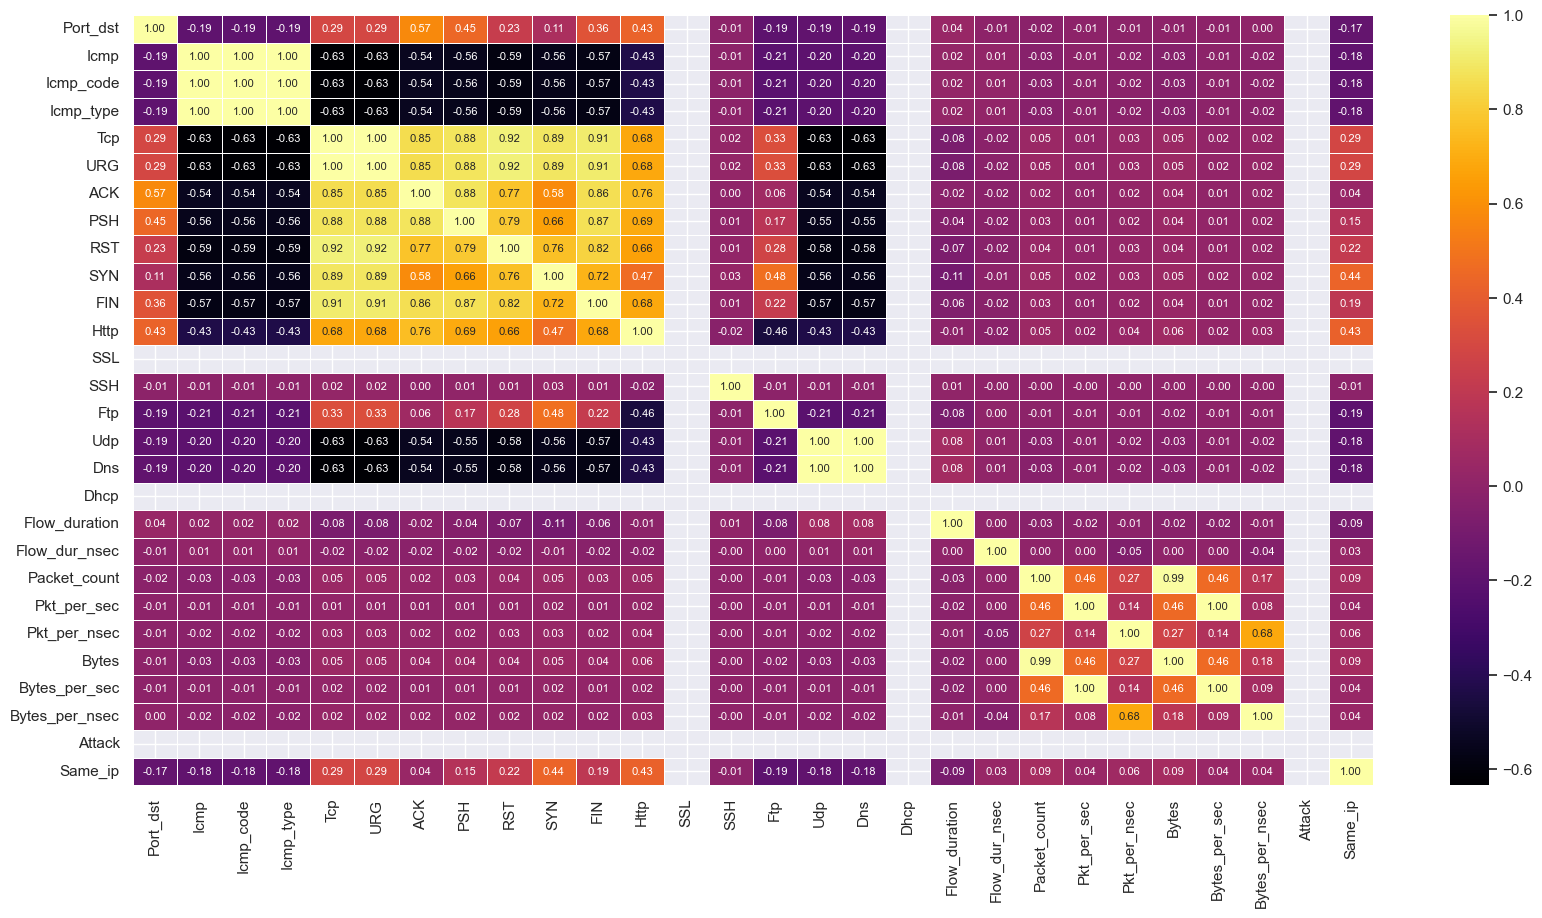

In [7]:
cl = ['Attack_type']
corr = df.drop(cl, axis=1).corr(method='pearson')
sb.set(rc={'figure.figsize':(20,10)})
sb.heatmap(corr, 
           xticklabels=corr.columns,
           yticklabels=corr.columns,
           annot=True,
           fmt=".2f",  # Format annotations to display 2 digits after decimal point
           linewidth=0.4,
           cmap='inferno',  # Choose colormap (optional)
           annot_kws={"size": 8})  # Set fontsize for annotations

In [8]:
columns_to_drop = ['Bytes', 'Bytes_per_sec', 'Attack','Dns', 'Dhcp','Icmp_code', 'Icmp_type', 'URG','SSL', 'Tcp']
df = df.drop(columns=columns_to_drop)

# Label Encoding

In [9]:
def label_encoder(colum):
    le = LabelEncoder()
    le.fit(colum)
    print(list(le.classes_))
    return le.transform(colum)

def data_pre(df):
    liste=["Attack_type"]
    for i in liste:
      df[i]=label_encoder(df[i])
data_pre(df)
print(df.groupby("Attack_type").size())

['HTTP_flood', 'ICMP_flood', 'LAND_attack', 'SLOWLORIS', 'SYN_flood', 'UDP_flood']
Attack_type
0    131225
1    113950
2     99681
3    100680
4    125312
5    113120
dtype: int64


# Filtrage des ports

In [10]:
port_count = df['Port_dst'].value_counts().sort_values(ascending=False)
port_count = port_count.head(10)
for port, count in port_count.items():
    print(f"Port: {port}, Count: {count}")

Port: 80.0, Count: 228016
Port: 21.0, Count: 120279
Port: -1.0, Count: 113950
Port: 53.0, Count: 113120
Port: 22.0, Count: 400
Port: 44808.0, Count: 63
Port: 44600.0, Count: 62
Port: 43952.0, Count: 58
Port: 43894.0, Count: 58
Port: 43910.0, Count: 58


In [11]:
ports = [21, 22, 53, 80, 443, -1]

def adjust_port(x):
    if x in ports:
        return x
    else:
        return 0

df['Port_dst'] = df['Port_dst'].apply(adjust_port)

In [12]:
port_count = df['Port_dst'].value_counts().sort_values(ascending=False)
port_count = port_count.head(10)
for port, count in port_count.items():
    print(f"Port: {port}, Count: {count}")

Port: 80.0, Count: 228016
Port: 21.0, Count: 120279
Port: -1.0, Count: 113950
Port: 53.0, Count: 113120
Port: 0.0, Count: 108203
Port: 22.0, Count: 400


# Handling imbalanced data

Class=4, n=125312 (18.321%)
Class=5, n=113120 (16.539%)
Class=1, n=113950 (16.660%)
Class=0, n=131225 (19.186%)
Class=2, n=99681 (14.574%)
Class=3, n=100680 (14.720%)


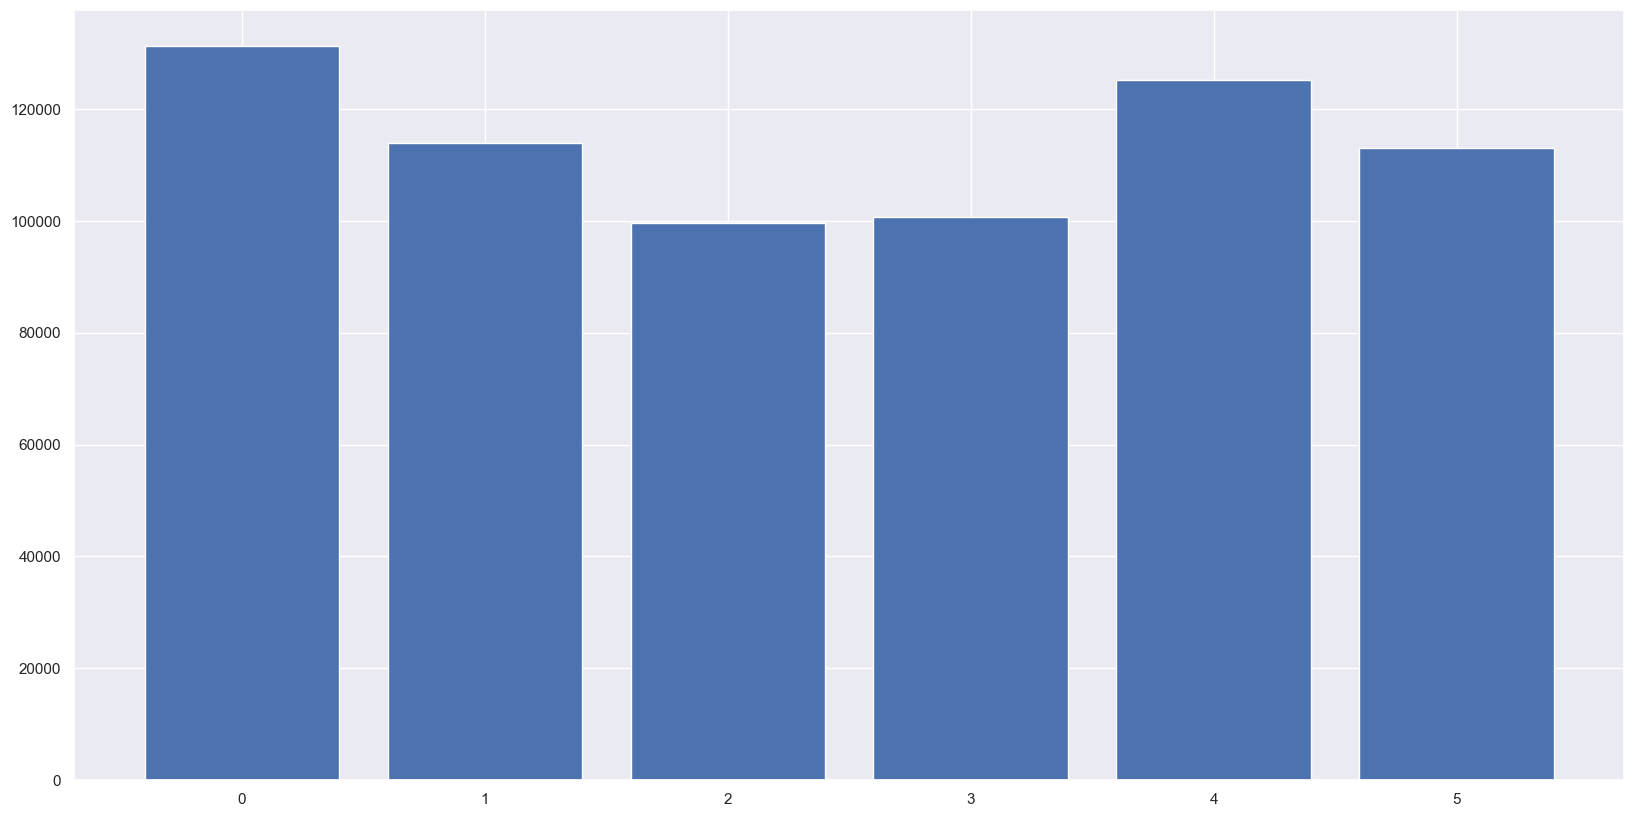

In [13]:
from collections import Counter
import matplotlib.pyplot as plt
X = df.drop('Attack_type', axis=1)
y = df['Attack_type']

# Compter les occurrences de chaque classe dans y
counter = Counter(y)
for k, v in counter.items():
    per = v / len(y) * 100
    print('Class=%s, n=%d (%.3f%%)' % (k, v, per))

plt.figure()
plt.bar(counter.keys(), counter.values())
def float_format_3(x):
    return f"{x:.1f}"

Class=4, n=131225 (16.667%)
Class=5, n=131225 (16.667%)
Class=1, n=131225 (16.667%)
Class=0, n=131225 (16.667%)
Class=2, n=131225 (16.667%)
Class=3, n=131225 (16.667%)


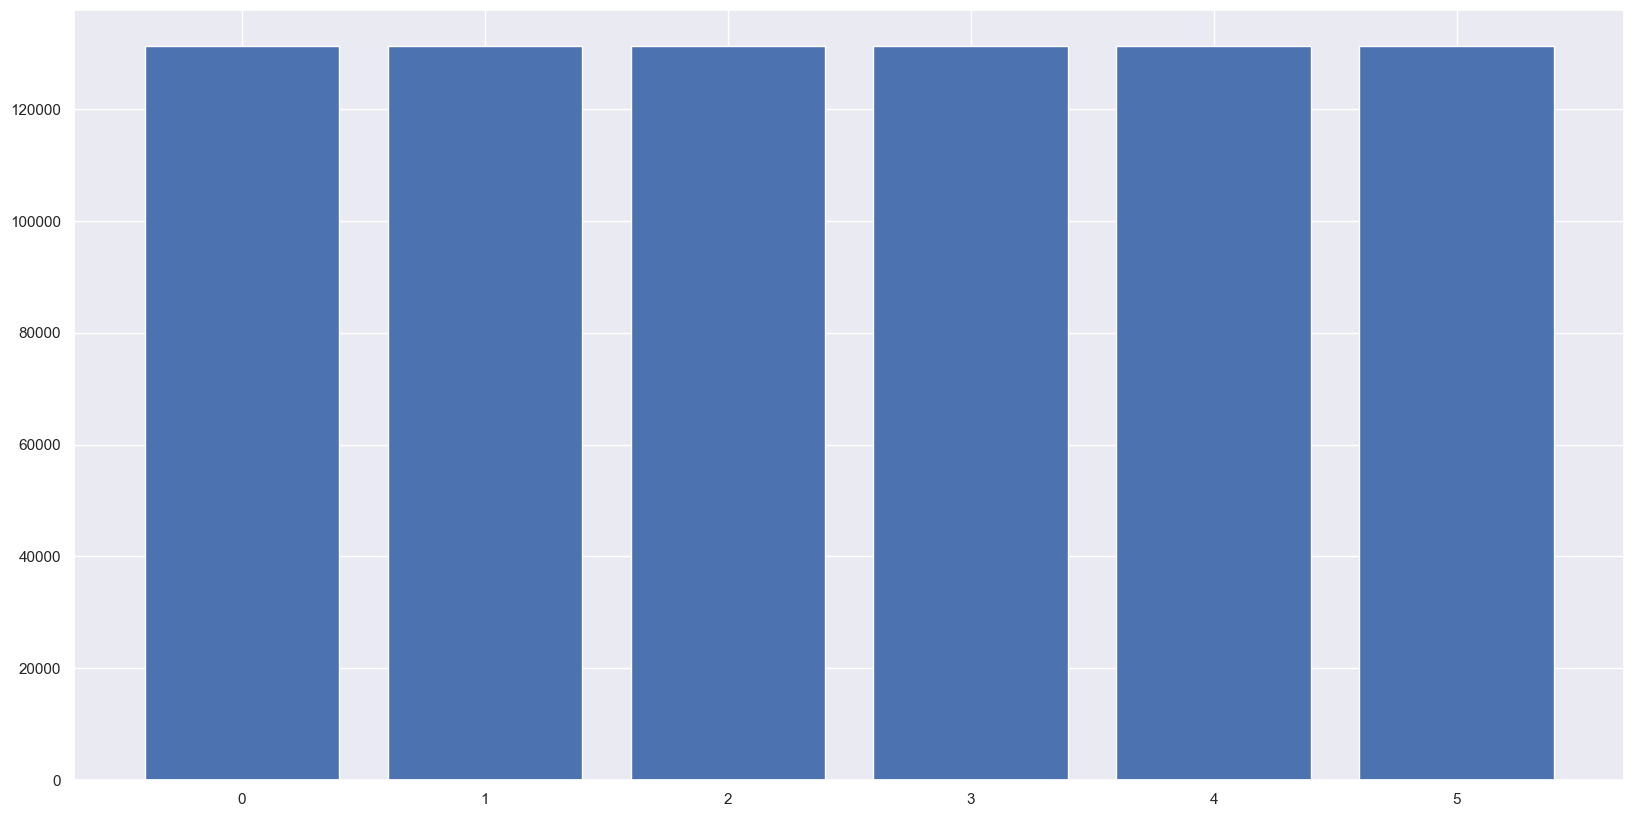

In [14]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=42)
X, y = oversample.fit_resample(X, y)
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
plt.figure()
plt.bar(counter.keys(), counter.values())
plt.show()

# Split data

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print('x_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('x_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)

x_train.shape:  (629880, 18)
y_train.shape:  (629880,)
x_test.shape:  (157470, 18)
y_test.shape:  (157470,)


# Normalisation

In [16]:
col = ['Port_dst',"Flow_duration","Flow_dur_nsec","Packet_count", "Pkt_per_sec","Pkt_per_nsec",'Bytes_per_nsec']
X_train[col].describe()

,Port_dst,Flow_duration,Flow_dur_nsec,Packet_count,Pkt_per_sec,Pkt_per_nsec,Bytes_per_nsec
count,629880.000000,629880.000000,6.298800e+05,629880.000000,629880.000000,6.298800e+05,6.298800e+05
mean,40.070747,28.154123,4.954641e+08,0.772465,0.076887,5.079565e-09,3.339165e-07
std,34.299053,18.114999,2.874570e+08,11.072653,3.315121,1.155339e-07,9.444502e-06
min,-1.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000e+00,0.000000e+00
25%,0.000000,12.000000,2.480000e+08,0.000000,0.000000,0.000000e+00,0.000000e+00
50%,53.000000,27.000000,4.910000e+08,0.000000,0.000000,0.000000e+00,0.000000e+00
75%,80.000000,44.000000,7.440000e+08,0.000000,0.000000,0.000000e+00,0.000000e+00
max,80.000000,70.000000,9.990000e+08,2692.000000,2579.000000,2.200000e-05,4.674000e-03


In [17]:
scaler = MinMaxScaler()
num=['Port_dst', "Pkt_per_sec","Flow_dur_nsec","Pkt_per_nsec",'Bytes_per_nsec']
scaler.fit(X_train[num])
X[num]=scaler.transform(X[num])
X_train[num] = scaler.transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

scaler = StandardScaler()
num=["Flow_duration","Packet_count"]
scaler.fit(X_train[num])
X[num]=scaler.transform(X[num])
X_train[num] = scaler.transform(X_train[num])
X_test[num] = scaler.transform(X_test[num])

In [18]:
unique, countss = np.unique(y_train, return_counts=True)
dict(zip(unique, countss))
unique, countss = np.unique(y_test, return_counts=True)
dict(zip(unique, countss))
outcome_labels = sorted(unique)

In [19]:
def metrics_error(y_true,y_pred):
    # calculate MAE, MSE, RMSE
    print('accuracy : '+str(metrics.accuracy_score(y_true, y_pred)))
    print('mean absolute error : '+str(metrics.mean_absolute_error(y_true, y_pred)))
    print('mean squared error : '+str(metrics.mean_squared_error(y_true, y_pred)))
    print('root mean squared error : '+str(np.sqrt(metrics.mean_squared_error(y_true, y_pred))))

def confixion_metrix(y_test, yy_pred_reg, outcome_labels):
    # Confusion Matrix
    sns.heatmap(
        metrics.confusion_matrix(y_test, yy_pred_reg),
        annot=True,
        fmt="d",
        xticklabels=outcome_labels,
        yticklabels=outcome_labels
    )
    plt.show()

#target=['HTTP_flood', 'ICMP_flood','SYN_flood', 'UDP_flood', 'LAND_Attack']
target=['HTTP_flood', 'ICMP_flood','SYN_flood', 'UDP_flood', 'SLOWLORIS', 'LAND_Attack']

# Decision Tree

**************Train Decision Tree*****************
accuracy : 0.9928002159141424
mean absolute error : 0.021556486949895218
mean squared error : 0.06465993522575729
root mean squared error : 0.25428317920333876


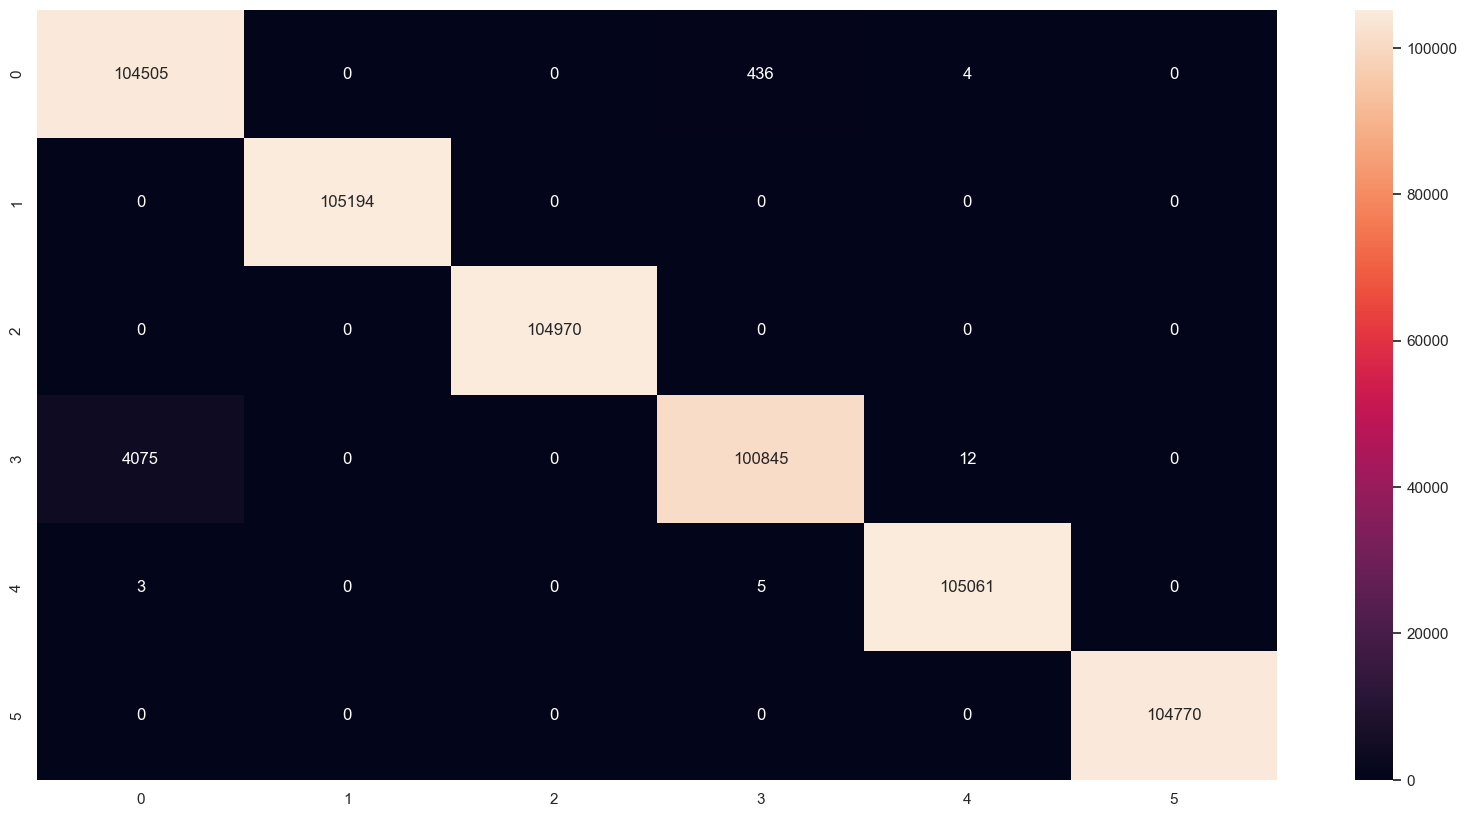

Classification report Training
              precision    recall  f1-score   support

  HTTP_flood       0.96      1.00      0.98    104945
  ICMP_flood       1.00      1.00      1.00    105194
   SYN_flood       1.00      1.00      1.00    104970
   UDP_flood       1.00      0.96      0.98    104932
   SLOWLORIS       1.00      1.00      1.00    105069
 LAND_Attack       1.00      1.00      1.00    104770

    accuracy                           0.99    629880
   macro avg       0.99      0.99      0.99    629880
weighted avg       0.99      0.99      0.99    629880



In [20]:
DT_class=DecisionTreeClassifier(random_state=42)
DT_class.fit(X_train,y_train)
y_pred_DT=DT_class.predict(X_test)
y_pred_DT_train=DT_class.predict(X_train)
print('**************Train Decision Tree*****************')
metrics_error(y_train,y_pred_DT_train)
cm = metrics.confusion_matrix(y_train, y_pred_DT_train)
confixion_metrix(y_train,y_pred_DT_train, outcome_labels)
print('Classification report Training')
print(classification_report(y_train,y_pred_DT_train, target_names=target))

**************Test Decision Tree Classifier*****************

accuracy : 0.9687178510192418
mean absolute error : 0.09370673779132534
mean squared error : 0.28101860671874007
root mean squared error : 0.5301118813219904


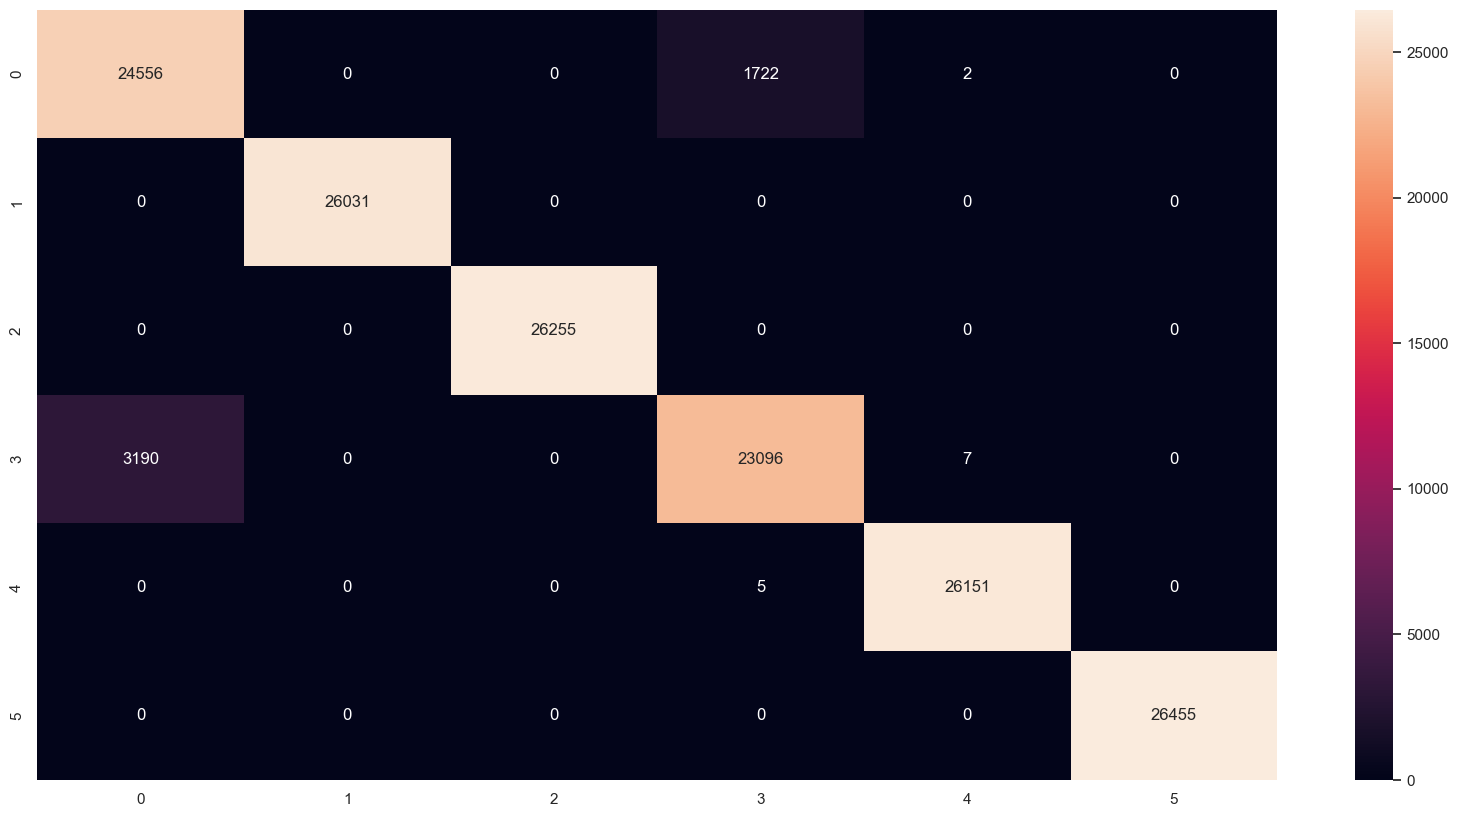

Classification report Test
              precision    recall  f1-score   support

  HTTP_flood       0.89      0.93      0.91     26280
  ICMP_flood       1.00      1.00      1.00     26031
   SYN_flood       1.00      1.00      1.00     26255
   UDP_flood       0.93      0.88      0.90     26293
   SLOWLORIS       1.00      1.00      1.00     26156
 LAND_Attack       1.00      1.00      1.00     26455

    accuracy                           0.97    157470
   macro avg       0.97      0.97      0.97    157470
weighted avg       0.97      0.97      0.97    157470



In [21]:
print('**************Test Decision Tree Classifier*****************')
print()
metrics_error(y_test,y_pred_DT)
confixion_metrix(y_test, y_pred_DT, outcome_labels)
print('Classification report Test')
print(classification_report(y_test, y_pred_DT, target_names=target))

# Logistic regression

**************Train Logistic Regression*****************
accuracy : 0.8602527465548994
mean absolute error : 0.4197243919476726
mean squared error : 1.2611037022925002
root mean squared error : 1.1229887364940487


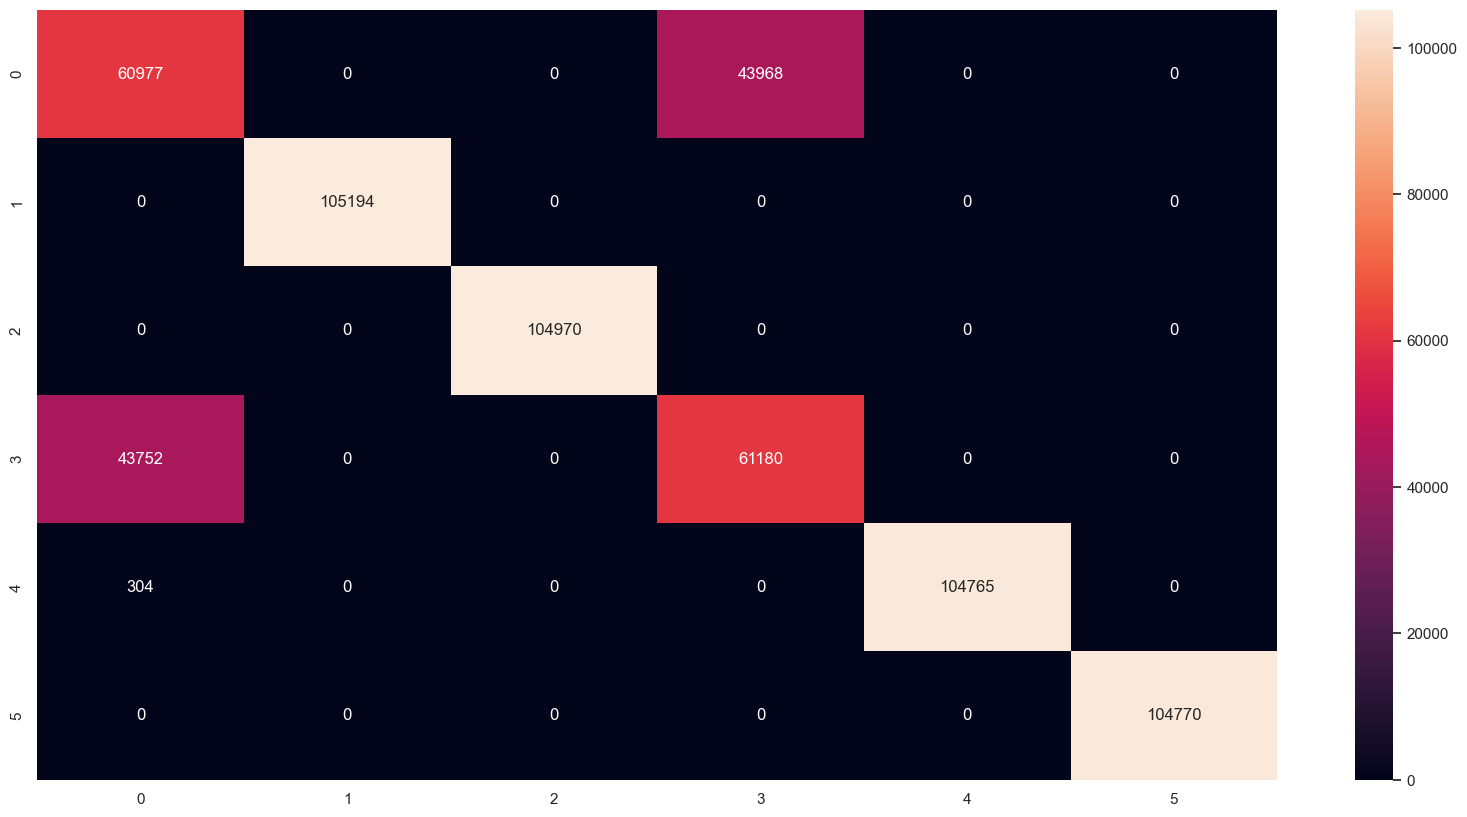

Classification report Training
              precision    recall  f1-score   support

  HTTP_flood       0.58      0.58      0.58    104945
  ICMP_flood       1.00      1.00      1.00    105194
   SYN_flood       1.00      1.00      1.00    104970
   UDP_flood       0.58      0.58      0.58    104932
   SLOWLORIS       1.00      1.00      1.00    105069
 LAND_Attack       1.00      1.00      1.00    104770

    accuracy                           0.86    629880
   macro avg       0.86      0.86      0.86    629880
weighted avg       0.86      0.86      0.86    629880



In [22]:
log_reg = LogisticRegression(max_iter=500,random_state=42)
log_reg.fit(X_train,y_train)
y_pred_reg=log_reg.predict(X_test)
y_pred_reg_train=log_reg.predict(X_train)
print('**************Train Logistic Regression*****************')
metrics_error(y_train,y_pred_reg_train)
cm = metrics.confusion_matrix(y_train, y_pred_reg_train)
confixion_metrix(y_train, y_pred_reg_train, outcome_labels)
print('Classification report Training')
print(classification_report(y_train, y_pred_reg_train, target_names=target))

**************Test Logistic Regression*****************
accuracy : 0.8609258906458374
mean absolute error : 0.41767320759509746
mean squared error : 1.25482314091573
root mean squared error : 1.120188886266834


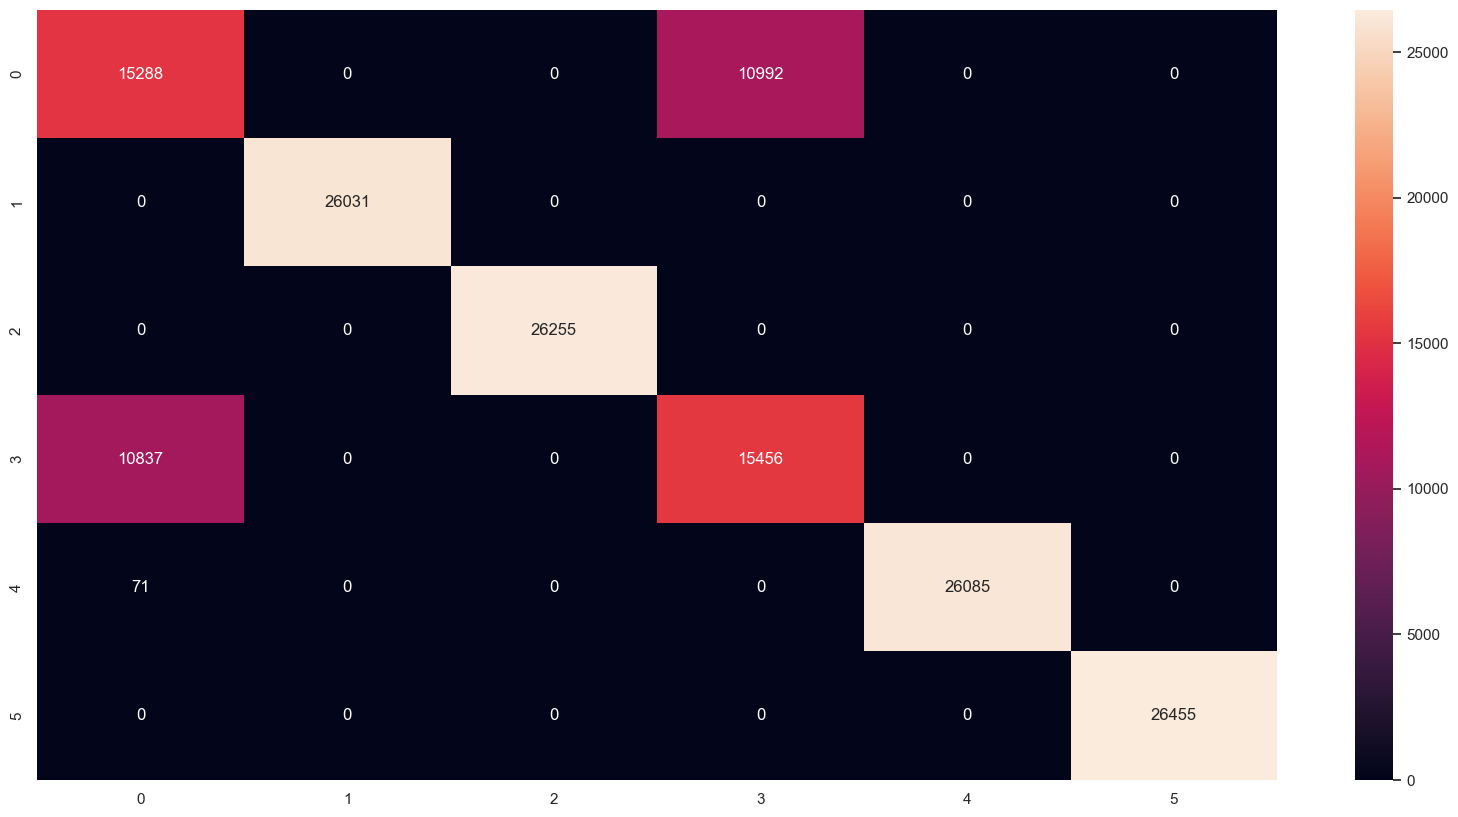

Classification report Test
              precision    recall  f1-score   support

  HTTP_flood       0.58      0.58      0.58     26280
  ICMP_flood       1.00      1.00      1.00     26031
   SYN_flood       1.00      1.00      1.00     26255
   UDP_flood       0.58      0.59      0.59     26293
   SLOWLORIS       1.00      1.00      1.00     26156
 LAND_Attack       1.00      1.00      1.00     26455

    accuracy                           0.86    157470
   macro avg       0.86      0.86      0.86    157470
weighted avg       0.86      0.86      0.86    157470



In [23]:
print('**************Test Logistic Regression*****************')
metrics_error(y_test,y_pred_reg)
cm = metrics.confusion_matrix(y_test, y_pred_reg)
confixion_metrix(y_test, y_pred_reg, outcome_labels)
print('Classification report Test')
print(classification_report(y_test, y_pred_reg, target_names=target))

# Random forest

**************Train Random Forest *****************
accuracy : 0.9927208357147393
mean absolute error : 0.0217946275481044
mean squared error : 0.06537435702038484
root mean squared error : 0.25568409614284743


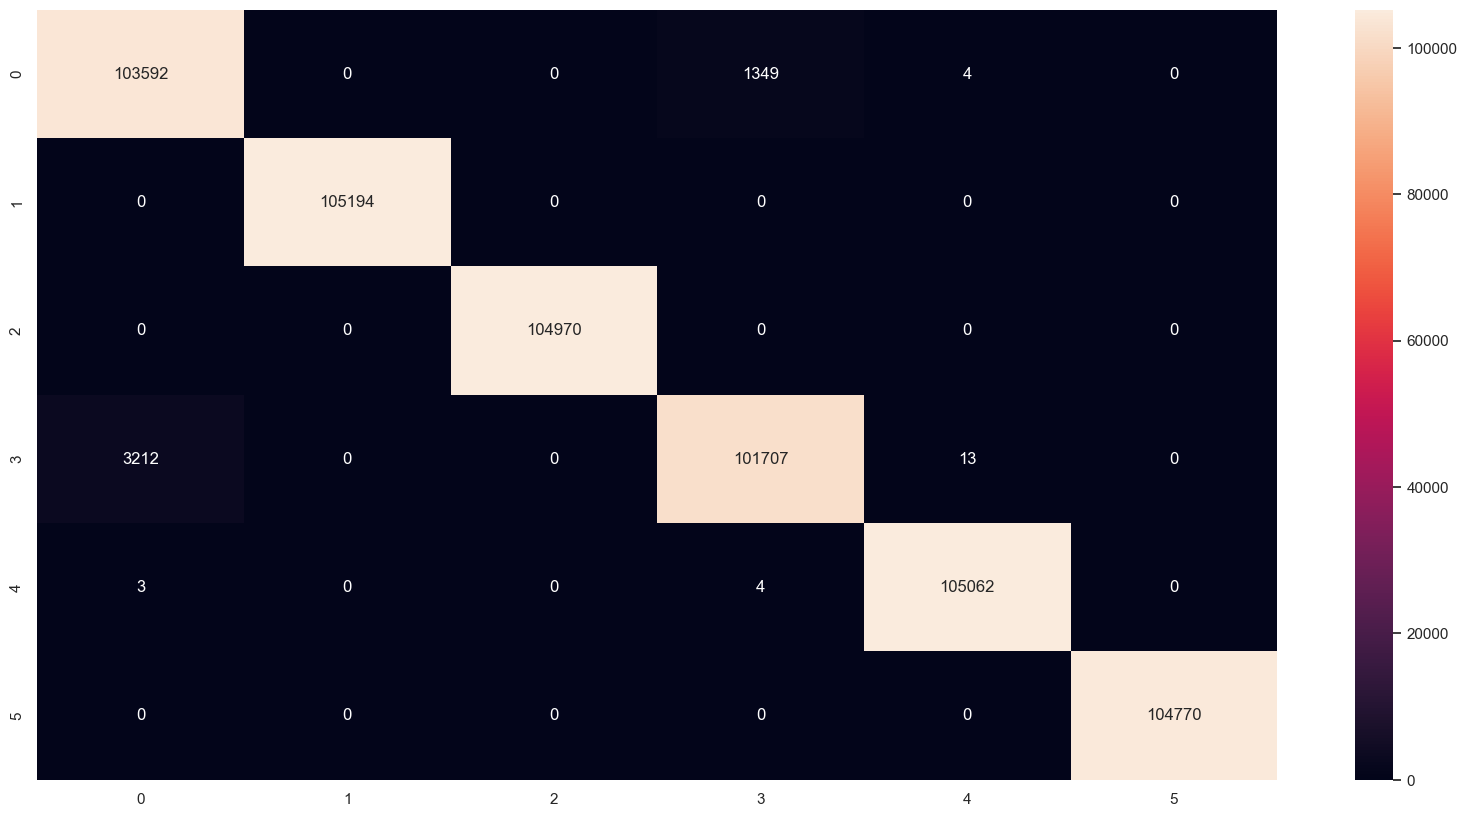

Classification report Training
              precision    recall  f1-score   support

  HTTP_flood       0.97      0.99      0.98    104945
  ICMP_flood       1.00      1.00      1.00    105194
   SYN_flood       1.00      1.00      1.00    104970
   UDP_flood       0.99      0.97      0.98    104932
   SLOWLORIS       1.00      1.00      1.00    105069
 LAND_Attack       1.00      1.00      1.00    104770

    accuracy                           0.99    629880
   macro avg       0.99      0.99      0.99    629880
weighted avg       0.99      0.99      0.99    629880



In [24]:
model_RF = RandomForestClassifier(random_state=42)
model_RF.fit(X_train,y_train)
y_predict_model_RF=model_RF.predict(X_test)
y_predict_train_model_RF=model_RF.predict(X_train)
print('**************Train Random Forest *****************')
metrics_error(y_train,y_predict_train_model_RF)
cm = metrics.confusion_matrix(y_train, y_predict_train_model_RF)
confixion_metrix(y_train, y_predict_train_model_RF, outcome_labels)
print('Classification report Training')
print(classification_report(y_train, y_predict_train_model_RF, target_names=target))

**************Test Random Forest *****************
accuracy : 0.9678732456975931
mean absolute error : 0.09626595542008001
mean squared error : 0.2887216612688131
root mean squared error : 0.5373282621161976


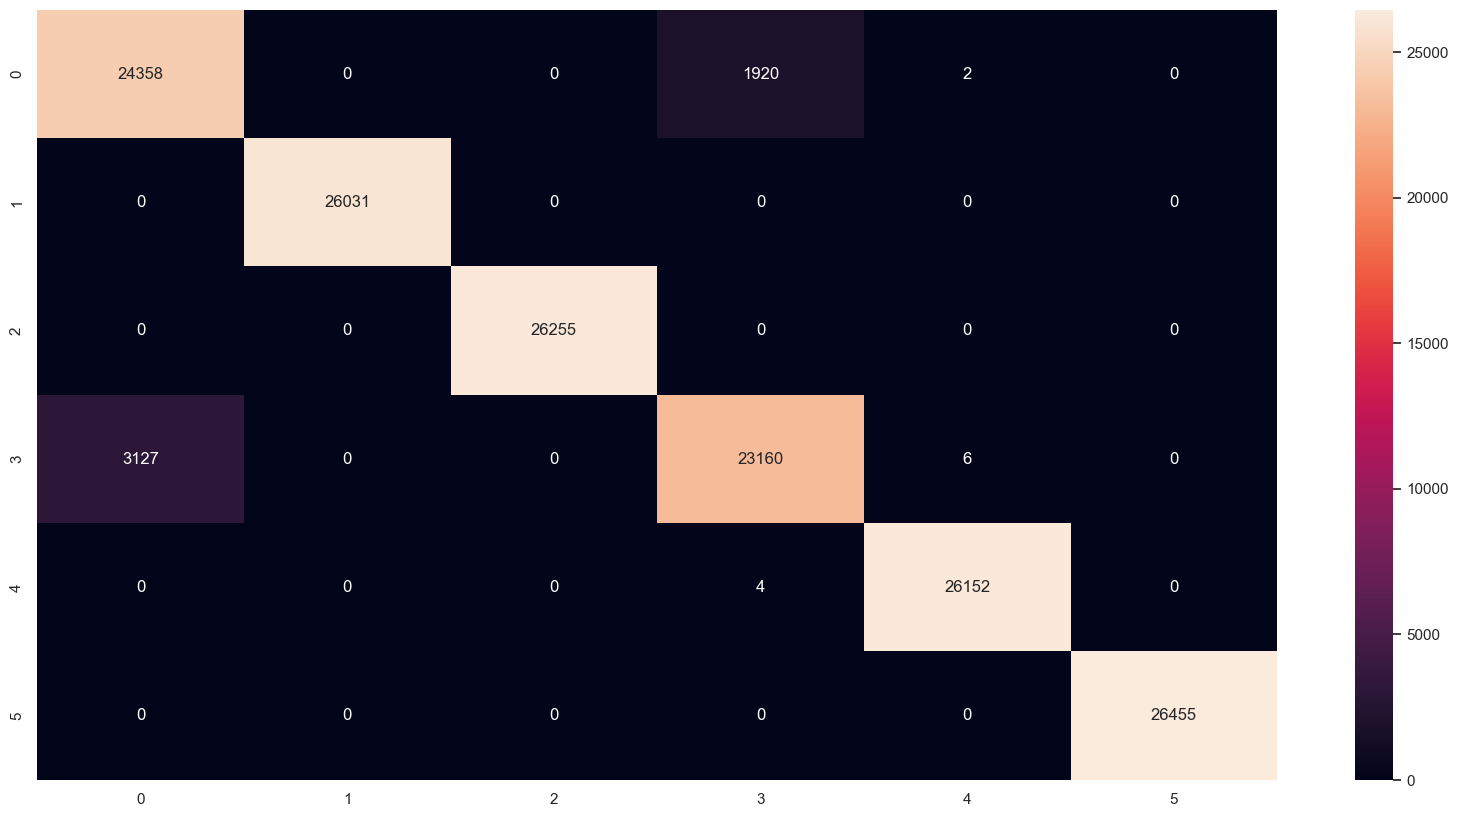

Classification report Test
              precision    recall  f1-score   support

  HTTP_flood       0.89      0.93      0.91     26280
  ICMP_flood       1.00      1.00      1.00     26031
   SYN_flood       1.00      1.00      1.00     26255
   UDP_flood       0.92      0.88      0.90     26293
   SLOWLORIS       1.00      1.00      1.00     26156
 LAND_Attack       1.00      1.00      1.00     26455

    accuracy                           0.97    157470
   macro avg       0.97      0.97      0.97    157470
weighted avg       0.97      0.97      0.97    157470



In [25]:
print('**************Test Random Forest *****************')
metrics_error(y_test,y_predict_model_RF)
cm = metrics.confusion_matrix(y_test, y_predict_model_RF)
confixion_metrix(y_test, y_predict_model_RF, outcome_labels)
print('Classification report Test')
print(classification_report(y_test, y_predict_model_RF, target_names=target))

# KNN neighbors

**************Train knn neighbors*****************
accuracy : 0.9714088397790055
mean absolute error : 0.08554169048072649
mean squared error : 0.25645043500349274
root mean squared error : 0.5064093551698001


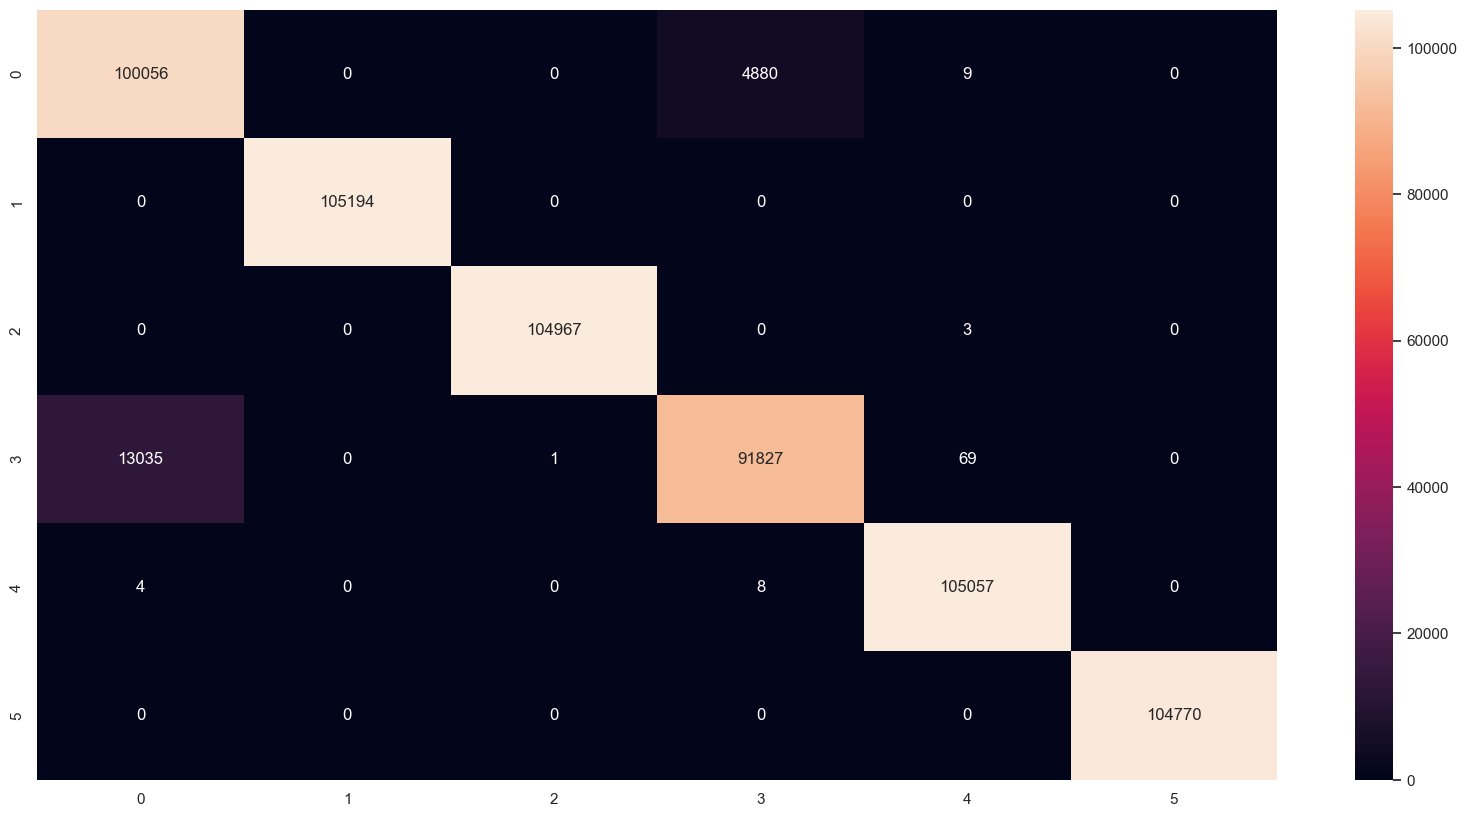

Classification report Training
              precision    recall  f1-score   support

  HTTP_flood       0.88      0.95      0.92    104945
  ICMP_flood       1.00      1.00      1.00    105194
   SYN_flood       1.00      1.00      1.00    104970
   UDP_flood       0.95      0.88      0.91    104932
   SLOWLORIS       1.00      1.00      1.00    105069
 LAND_Attack       1.00      1.00      1.00    104770

    accuracy                           0.97    629880
   macro avg       0.97      0.97      0.97    629880
weighted avg       0.97      0.97      0.97    629880



In [26]:
knn_model=KNeighborsClassifier()
knn_model.fit(X_train,y_train)
y_pred_knn=knn_model.predict(X_test)
y_pred_knn_train=knn_model.predict(X_train)
print('**************Train knn neighbors*****************')
metrics_error(y_train,y_pred_knn_train)
cm = metrics.confusion_matrix(y_train, y_pred_knn_train)
confixion_metrix(y_train, y_pred_knn_train, outcome_labels)
print('Classification report Training')
print(classification_report(y_train, y_pred_knn_train, target_names=target))

**************Test knn neighbors*****************
accuracy : 0.9597383628627675
mean absolute error : 0.12037213437480154
mean squared error : 0.3607988823267924
root mean squared error : 0.6006653663453491


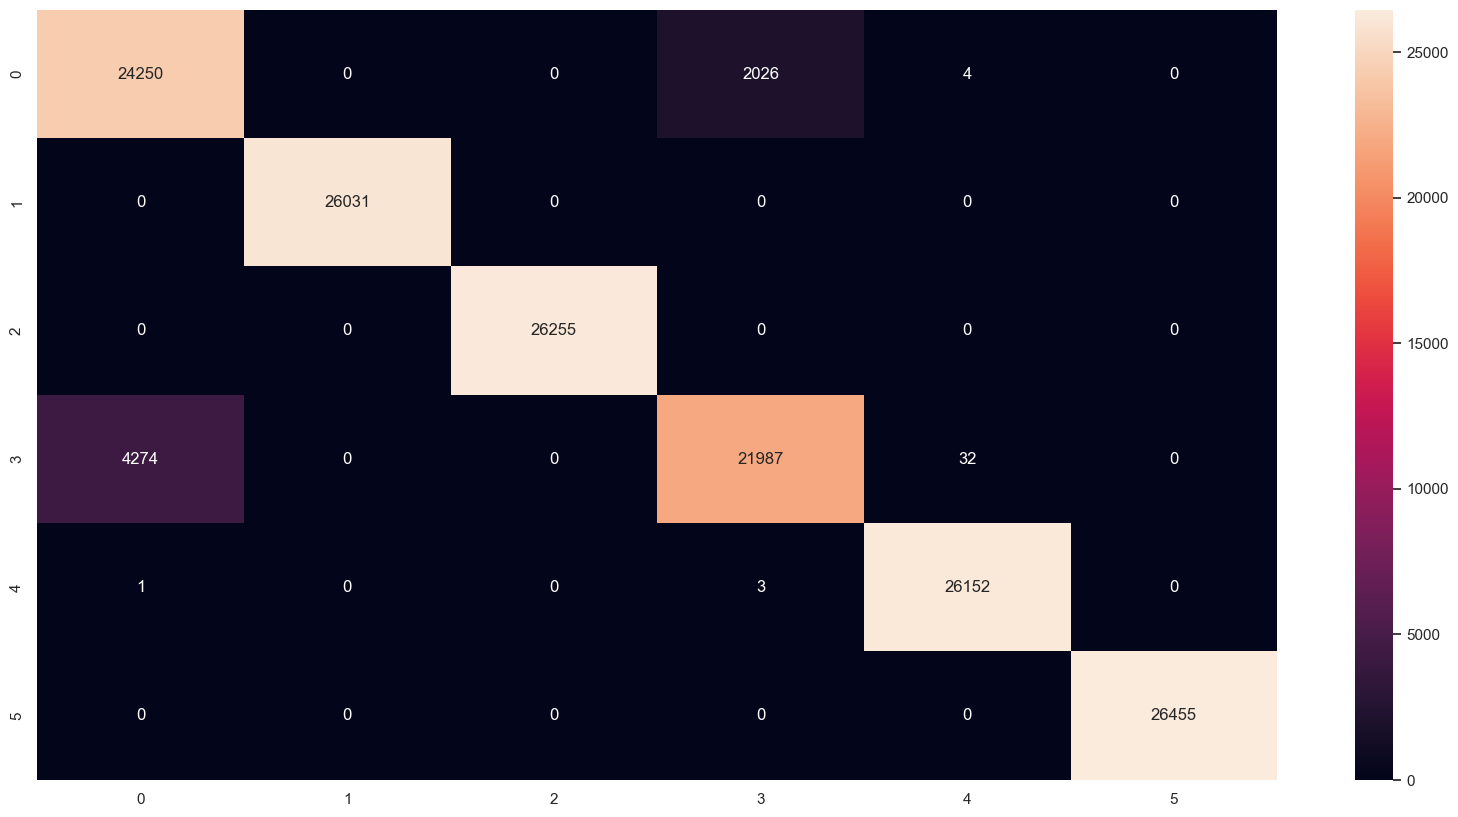

Classification report Test
              precision    recall  f1-score   support

  HTTP_flood       0.85      0.92      0.88     26280
  ICMP_flood       1.00      1.00      1.00     26031
   SYN_flood       1.00      1.00      1.00     26255
   UDP_flood       0.92      0.84      0.87     26293
   SLOWLORIS       1.00      1.00      1.00     26156
 LAND_Attack       1.00      1.00      1.00     26455

    accuracy                           0.96    157470
   macro avg       0.96      0.96      0.96    157470
weighted avg       0.96      0.96      0.96    157470



In [27]:
print('**************Test knn neighbors*****************')
metrics_error(y_test,y_pred_knn)
cm = metrics.confusion_matrix(y_test, y_pred_knn)
confixion_metrix(y_test, y_pred_knn, outcome_labels)
print('Classification report Test')
print(classification_report(y_test, y_pred_knn, target_names=target))

# Naive bayes

**************Train naive bayes*****************
accuracy : 0.8342208039626595
mean absolute error : 0.49782498253635615
mean squared error : 1.4954340509303359
root mean squared error : 1.2228794098071714


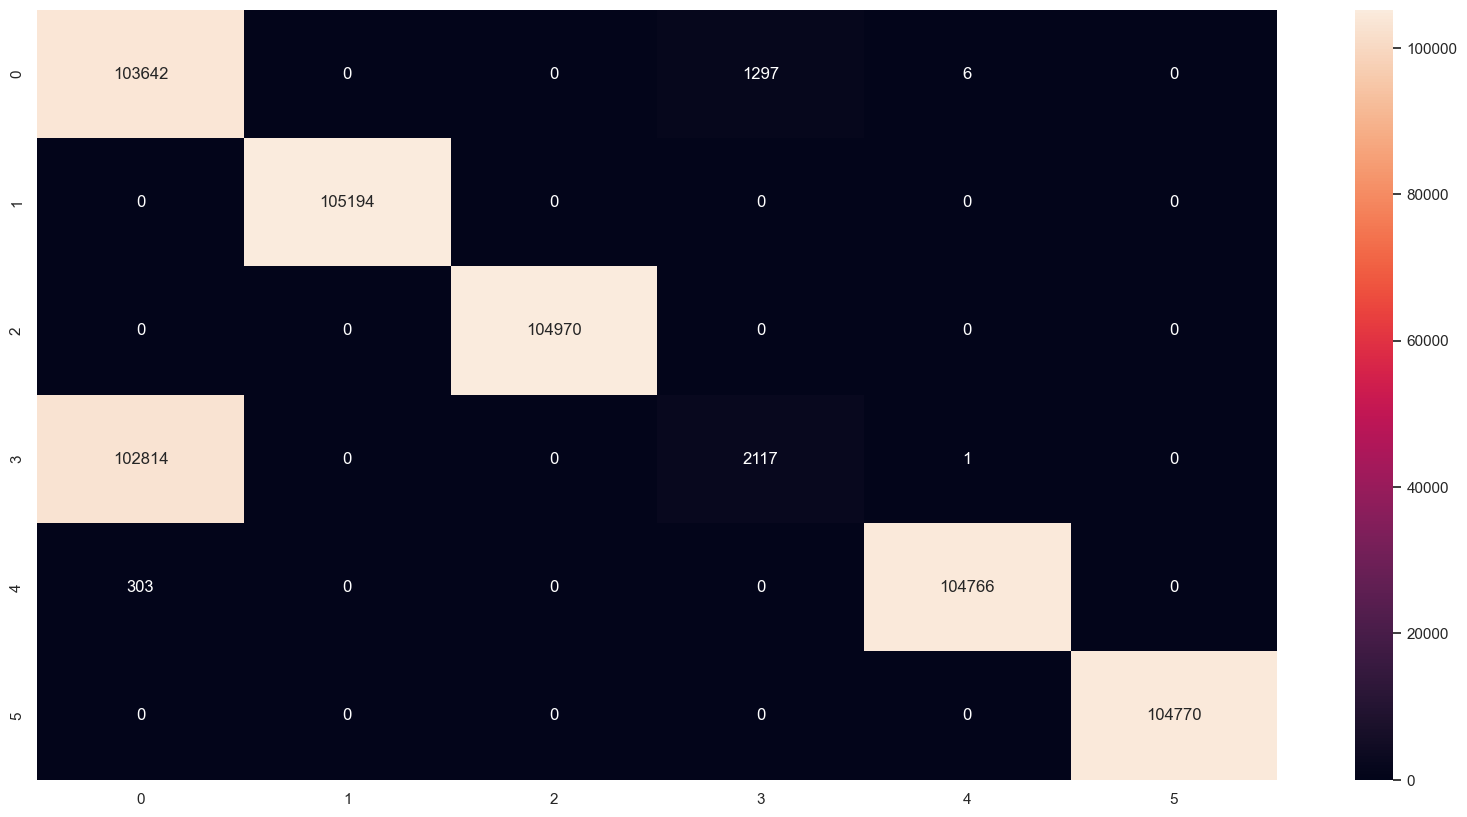

Classification report Training
              precision    recall  f1-score   support

  HTTP_flood       0.50      0.99      0.67    104945
  ICMP_flood       1.00      1.00      1.00    105194
   SYN_flood       1.00      1.00      1.00    104970
   UDP_flood       0.62      0.02      0.04    104932
   SLOWLORIS       1.00      1.00      1.00    105069
 LAND_Attack       1.00      1.00      1.00    104770

    accuracy                           0.83    629880
   macro avg       0.85      0.83      0.78    629880
weighted avg       0.85      0.83      0.78    629880



In [28]:
model_nb = GaussianNB()
model_nb.fit(X_train,y_train)
y_pred_NB=model_nb.predict(X_test)
y_pred_NB_train=model_nb.predict(X_train)
print('**************Train naive bayes*****************')
metrics_error(y_train,y_pred_NB_train)
cm = metrics.confusion_matrix(y_train, y_pred_NB_train)
confixion_metrix(y_train, y_pred_NB_train, outcome_labels)
print('Classification report Training')
print(classification_report(y_train, y_pred_NB_train, target_names=target))

**************Test naive bayes*****************

accuracy : 0.8339937765923668
mean absolute error : 0.49848225058741347
mean squared error : 1.4973010732202958
root mean squared error : 1.2236425430738733


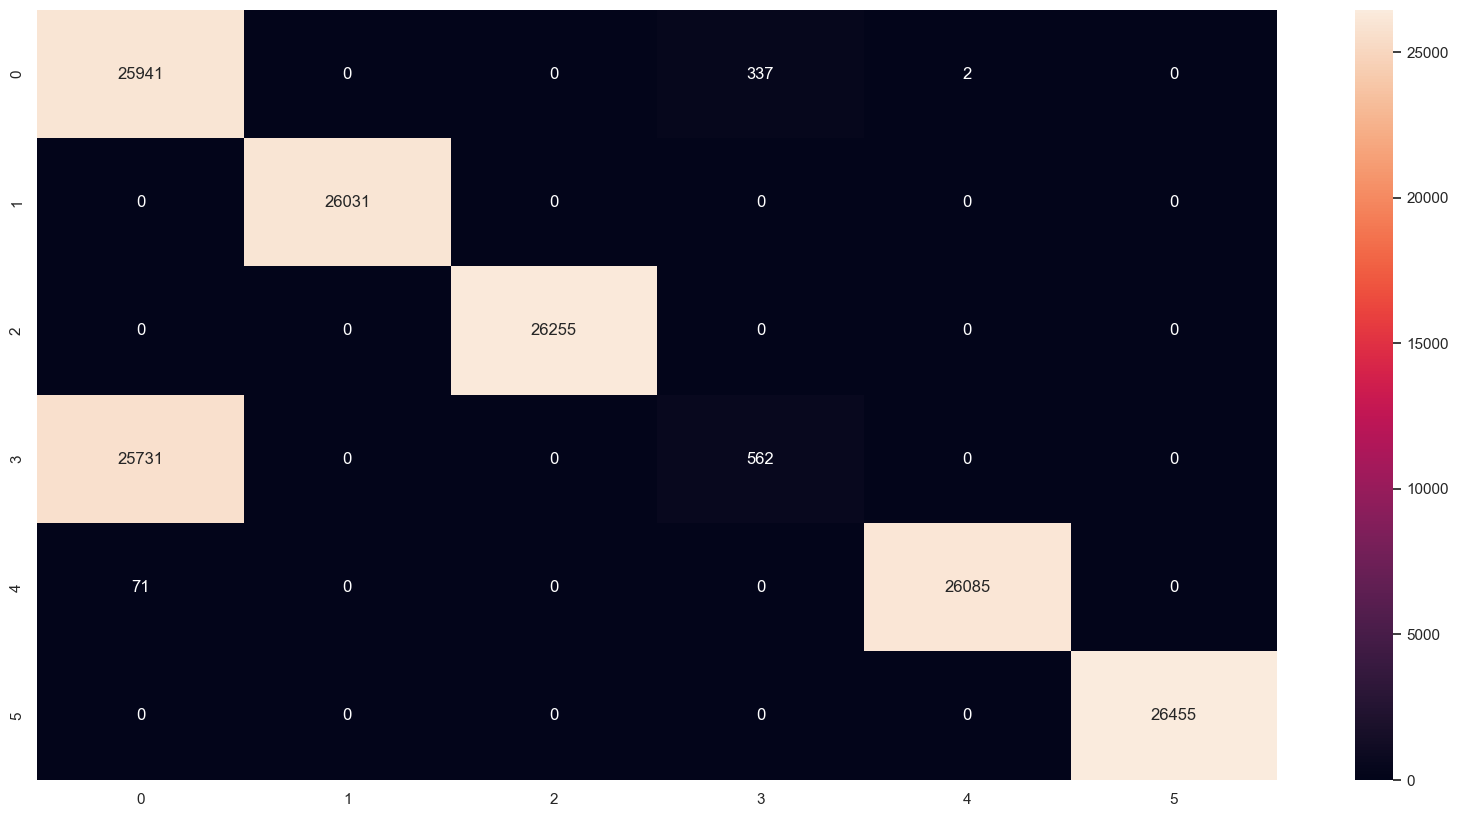

Classification report Test
              precision    recall  f1-score   support

  HTTP_flood       0.50      0.99      0.66     26280
  ICMP_flood       1.00      1.00      1.00     26031
   SYN_flood       1.00      1.00      1.00     26255
   UDP_flood       0.63      0.02      0.04     26293
   SLOWLORIS       1.00      1.00      1.00     26156
 LAND_Attack       1.00      1.00      1.00     26455

    accuracy                           0.83    157470
   macro avg       0.85      0.83      0.78    157470
weighted avg       0.85      0.83      0.78    157470



In [29]:
print('**************Test naive bayes*****************')
print()
metrics_error(y_test,y_pred_NB)
cm = metrics.confusion_matrix(y_test, y_pred_NB)
confixion_metrix(y_test, y_pred_NB, outcome_labels)
print('Classification report Test')
print(classification_report(y_test, y_pred_NB, target_names=target))

# XGboost

Accuracy train: 95.44%
accuracy : 0.954434177938655
mean absolute error : 0.13661014796469167
mean squared error : 0.4102336953070426
root mean squared error : 0.640494883123232


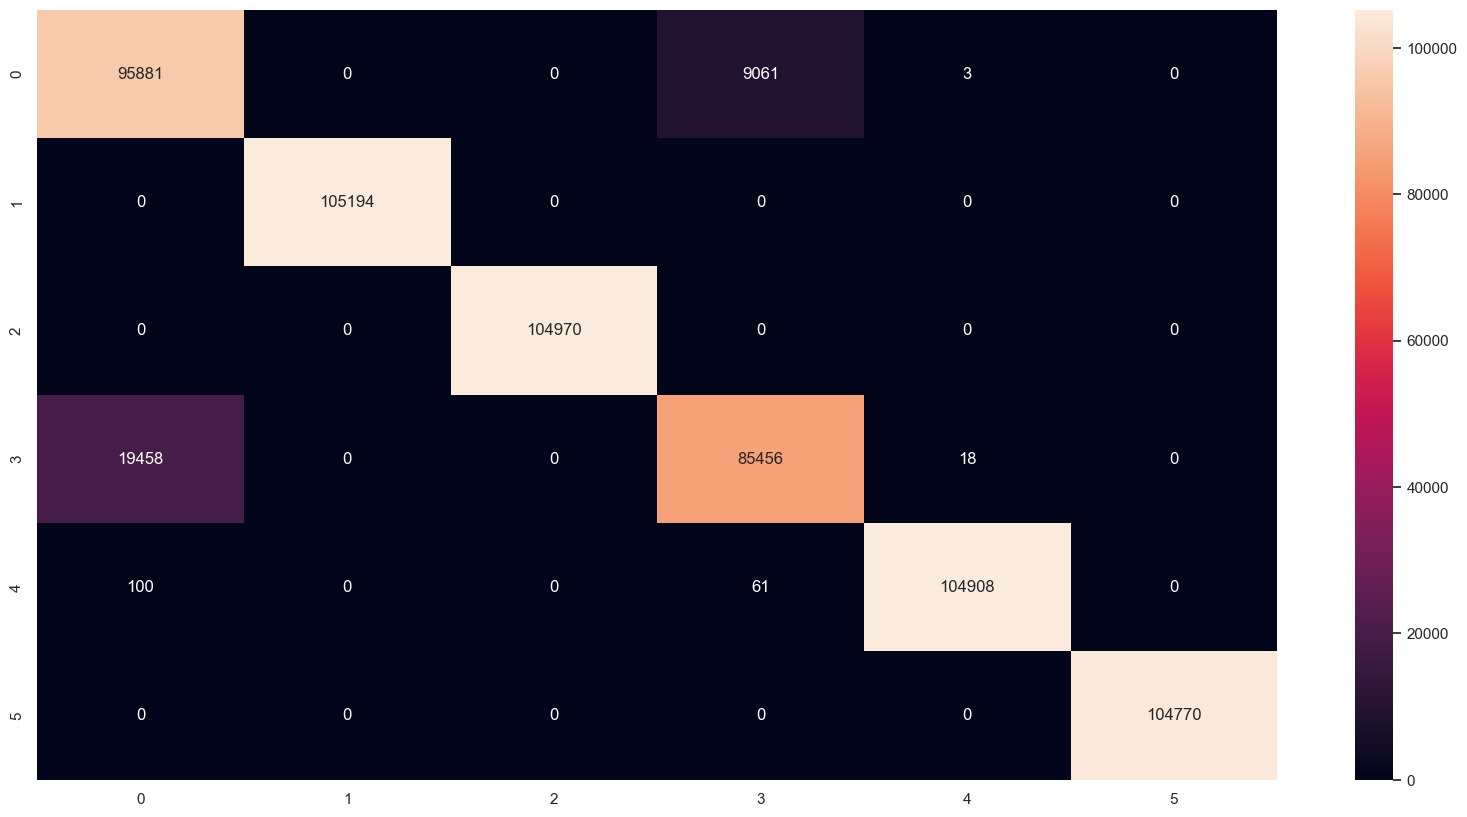

Classification report Training
              precision    recall  f1-score   support

  HTTP_flood       0.83      0.91      0.87    104945
  ICMP_flood       1.00      1.00      1.00    105194
   SYN_flood       1.00      1.00      1.00    104970
   UDP_flood       0.90      0.81      0.86    104932
   SLOWLORIS       1.00      1.00      1.00    105069
 LAND_Attack       1.00      1.00      1.00    104770

    accuracy                           0.95    629880
   macro avg       0.96      0.95      0.95    629880
weighted avg       0.96      0.95      0.95    629880



In [30]:
from xgboost import XGBClassifier
model = XGBClassifier()
model.fit(X_train, y_train)
y_pred_t = model.predict(X_train)
accuracy_train = metrics.accuracy_score(y_train, y_pred_t)
print("Accuracy train: %.2f%%" % (accuracy_train * 100.0))
metrics_error(y_train,y_pred_t)
cm = metrics.confusion_matrix(y_train, y_pred_t)
confixion_metrix(y_train, y_pred_t, outcome_labels)
print('Classification report Training')
print(classification_report(y_train, y_pred_t, target_names=target))

Accuracy test: 95.35%
accuracy : 0.9535403568933765
mean absolute error : 0.1393027243284435
mean squared error : 0.4183273004381787
root mean squared error : 0.6467822666386105


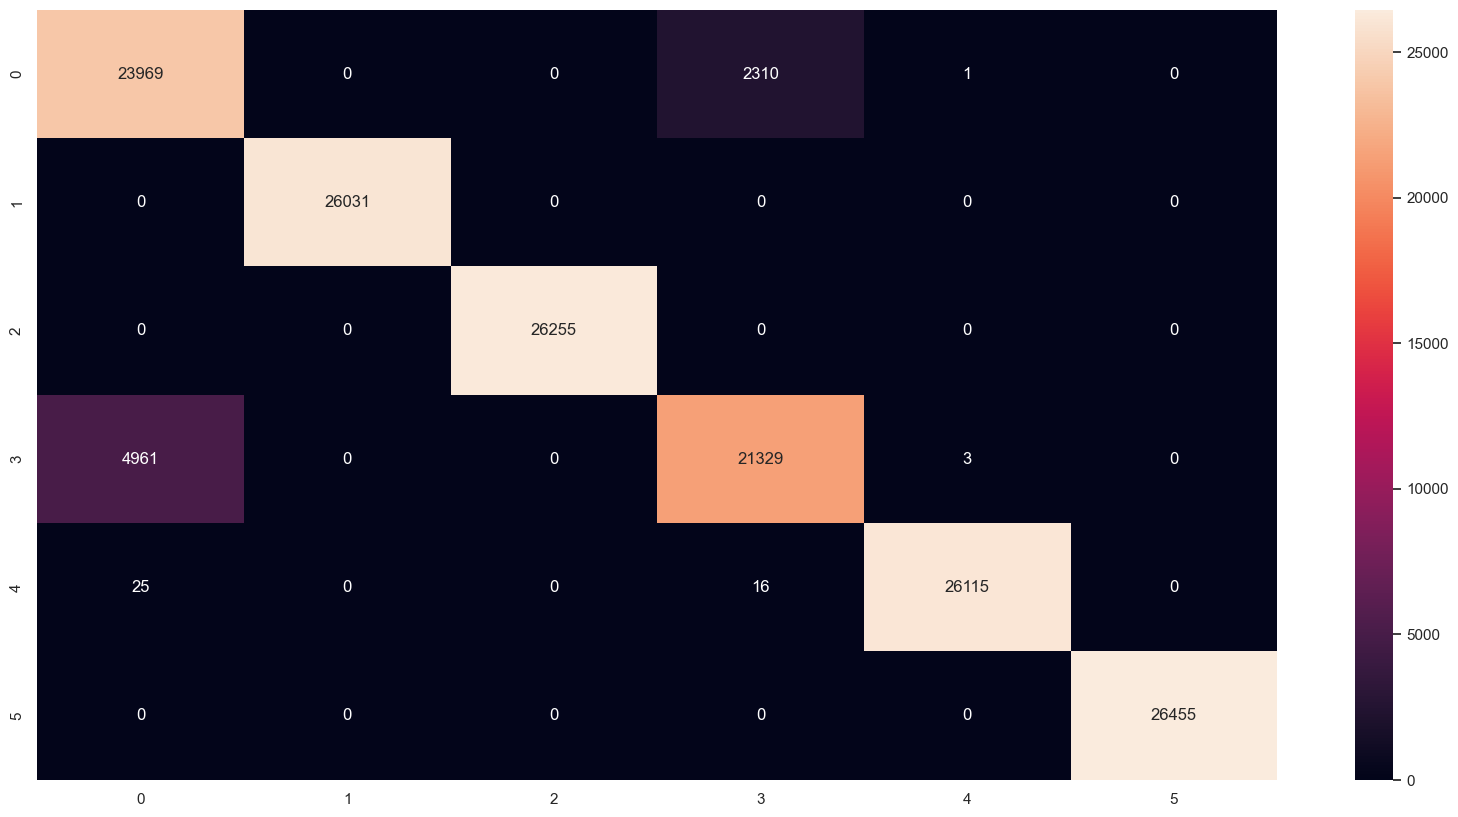

Classification report Test
              precision    recall  f1-score   support

  HTTP_flood       0.83      0.91      0.87     26280
  ICMP_flood       1.00      1.00      1.00     26031
   SYN_flood       1.00      1.00      1.00     26255
   UDP_flood       0.90      0.81      0.85     26293
   SLOWLORIS       1.00      1.00      1.00     26156
 LAND_Attack       1.00      1.00      1.00     26455

    accuracy                           0.95    157470
   macro avg       0.95      0.95      0.95    157470
weighted avg       0.95      0.95      0.95    157470



In [35]:
y_pred = model.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy test: %.2f%%" % (accuracy * 100.0))
metrics_error(y_test,y_pred)
cm = metrics.confusion_matrix(y_test, y_pred)
confixion_metrix(y_test, y_pred, outcome_labels)
print('Classification report Test')
print(classification_report(y_test, y_pred, target_names=target))

# Comparaison entre les algorithmes ML

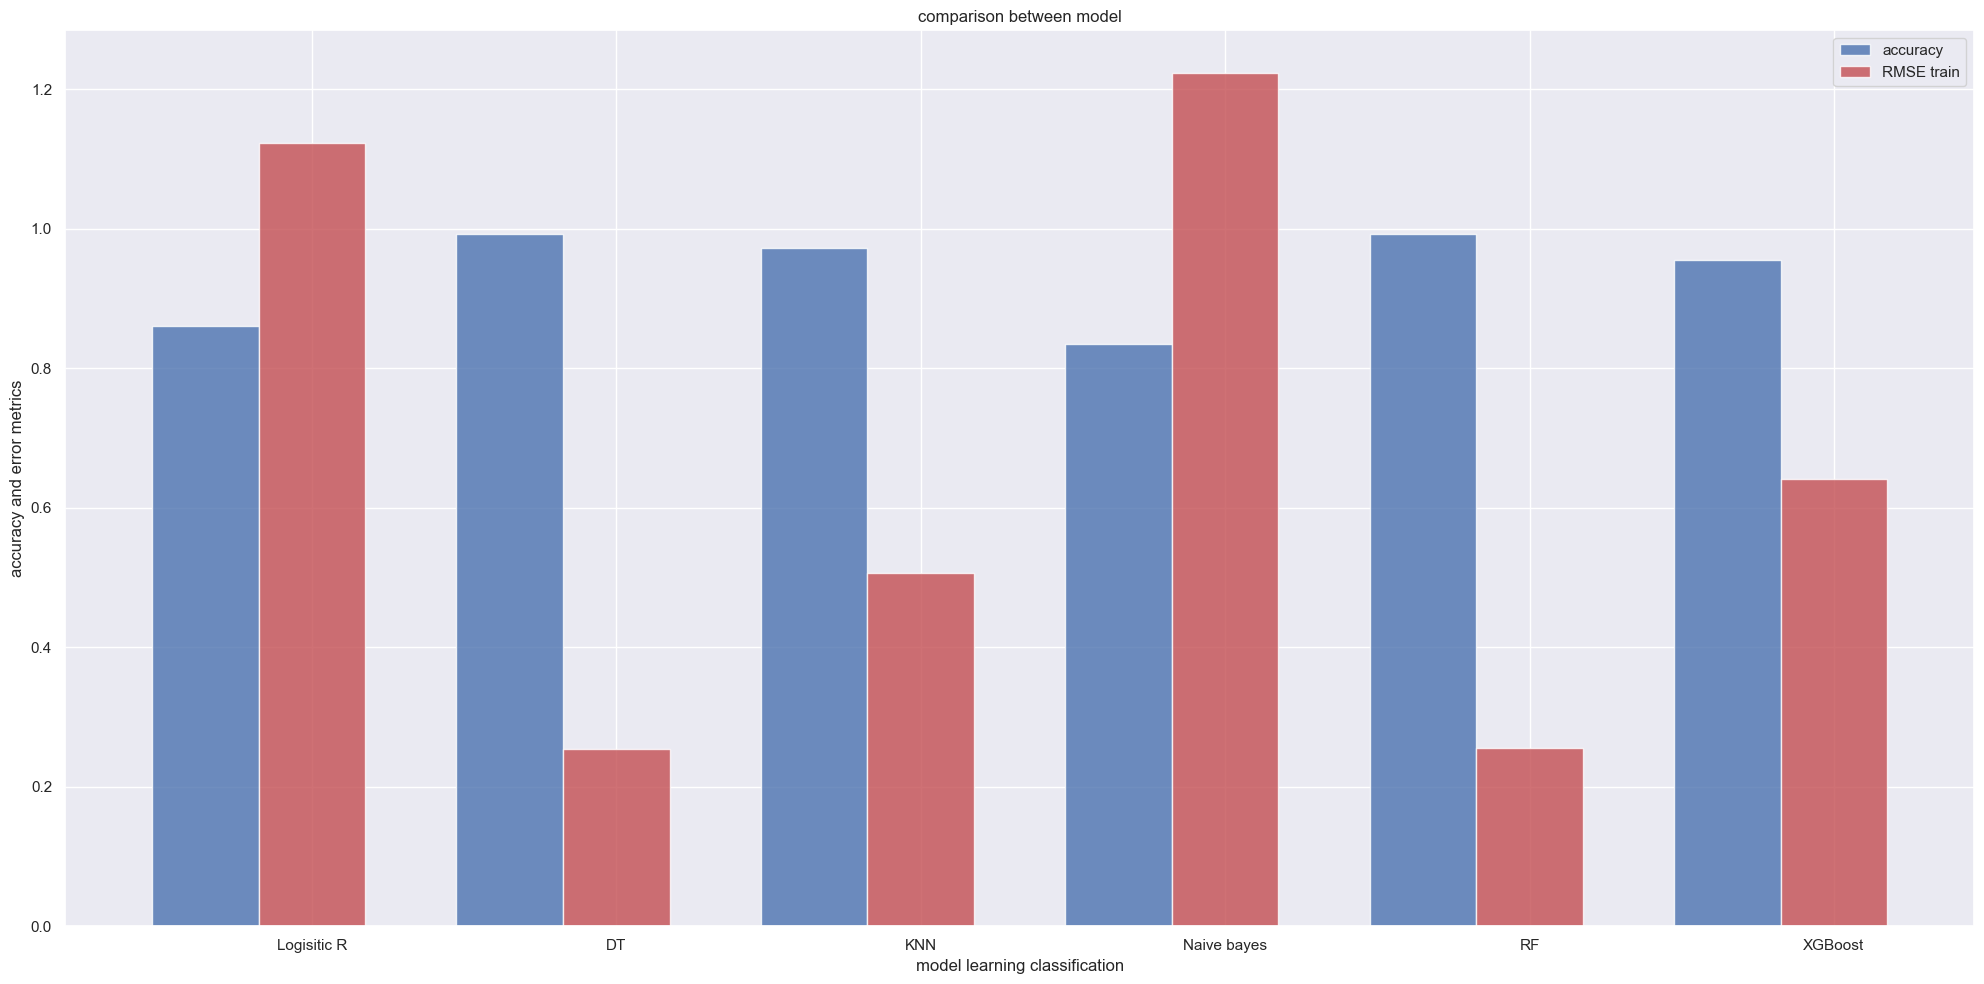

In [36]:
AS1=metrics.accuracy_score(y_test,y_pred_reg)
RMSE1=np.sqrt(metrics.mean_squared_error(y_test,y_pred_reg))
ASt1=metrics.accuracy_score(y_train,y_pred_reg_train)
RMSEt1=np.sqrt(metrics.mean_squared_error(y_train,y_pred_reg_train))
AS2=metrics.accuracy_score(y_test,y_pred_DT)
RMSE2=np.sqrt(metrics.mean_squared_error(y_test,y_pred_DT))
ASt2=metrics.accuracy_score(y_train,y_pred_DT_train)
RMSEt2=np.sqrt(metrics.mean_squared_error(y_train,y_pred_DT_train))
AS3=metrics.accuracy_score(y_test,y_pred_knn)
RMSE3=np.sqrt(metrics.mean_squared_error(y_test,y_pred_knn))

ASt3=metrics.accuracy_score(y_train,y_pred_knn_train)
RMSEt3=np.sqrt(metrics.mean_squared_error(y_train,y_pred_knn_train))
AS4=metrics.accuracy_score(y_test,y_pred_NB)
RMSE4=np.sqrt(metrics.mean_squared_error(y_test,y_pred_NB))

ASt4=metrics.accuracy_score(y_train,y_pred_NB_train)
RMSEt4=np.sqrt(metrics.mean_squared_error(y_train,y_pred_NB_train))
AS5=metrics.accuracy_score(y_test,y_predict_model_RF)
RMSE5=np.sqrt(metrics.mean_squared_error(y_test,y_predict_model_RF))

ASt5=metrics.accuracy_score(y_train,y_predict_train_model_RF)
RMSEt5=np.sqrt(metrics.mean_squared_error(y_train,y_predict_train_model_RF))
AS6=metrics.accuracy_score(y_test,y_pred)
RMSE6=np.sqrt(metrics.mean_squared_error(y_test,y_pred))

ASt6=metrics.accuracy_score(y_train,y_pred_t)
RMSEt6=np.sqrt(metrics.mean_squared_error(y_train,y_pred_t))

#visualisation perfermance
# data to plot
n_groups = 6
accuracy_score_models_train = (ASt1,ASt2,ASt3,ASt4,ASt5,ASt6)
error_metric_models_train = (RMSEt1,RMSEt2,RMSEt3,RMSEt4,RMSEt5,RMSEt6)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, accuracy_score_models_train, bar_width,
alpha=opacity,
color='b',
label='accuracy')

rects2 = plt.bar(index + bar_width, error_metric_models_train, bar_width,
alpha=opacity,
color='r',
label='RMSE train')

plt.xlabel('model learning classification')
plt.ylabel('accuracy and error metrics')
plt.title('comparison between model')
plt.xticks(index + bar_width, ('Logisitic R', 'DT', 'KNN', 'Naive bayes','RF','XGBoost'))
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
n_groups = 6
accuracy_score_models_test = (AS1,AS2,AS3,AS4,AS5,AS6)
error_metric_models_test = (RMSE1,RMSE2,RMSE3,RMSE4,RMSE5,RMSE6)
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, accuracy_score_models_test, bar_width,
alpha=opacity,
color='b',
label='accuracy')

rects2 = plt.bar(index + bar_width, error_metric_models_test, bar_width,
alpha=opacity,
color='r',
label='RMSE train')

plt.xlabel('model learning classification')
plt.ylabel('accuracy and error metrics')
plt.title('comparison between model')
plt.xticks(index + bar_width, ('Logisitic R', 'DT', 'KNN', 'Naive bayes','RF','XGBoost'))
plt.legend()

plt.tight_layout()
plt.show()